# Optimal control transport of trapped ions 
Transport of trapped ions is a key tool in trapped ion experiments. The task of moving one ion from A to B in the trap can be split into a series of interconnected optimization problems.

Reference: Optimal control transport of neutral atoms in optical tweezers at finite temperature, 
https://doi.org/10.1103/PhysRevResearch.6.033282

1. Reproduce the optimal control transport task discussed in the paper for the case of trapped ions. Formulate the problem as the 1D transport of one particle in a harmonic potential (rather than gaussian) and find a trajectory with minimal excitation using realistic trap parameters. You can use the python package referenced in the paper https://pypi.org/project/quocs-lib/ <br>
Bonus: transport two ions, use two control parameters (position and trap frequency), and minimize the excitation of both the COM and STR mode. 
2. Implement the transport in a realistic ion trap. Build an electrostatic model for a surface electrode trap, and find the voltage waveforms that reproduce the optimal control trajectory. I suggest using the python package pytrans https://pypi.org/project/pytrans/ (and related 
examples) 

By the due date please submit the presentation and the code. The final presentation will be 20 minutes long and you have to present the problem, methods and results. A final question on the program of the Quantum Information and Computing course will conclude the exam.

**Import zone**

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from qho_time_evolution import Param, Operators
from optimization import OptimalControl
from optimization import load_fom, load_best_results


from quocslib.Optimizer import Optimizer
import time
import plot

In [7]:
# SIMULATION PARAMETERS

xmin = -20.0
xmax = 20.0
num_x = 4000
tsim = 20
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS -> ADD WFC OFFSET

res = num_x
omega = 1.0
num_wfcs = 8
T = 1
linear_pulse = lambda t: t
times = np.linspace(0, tsim/2, num_t) - tsim/4
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [8]:
optimization_dictionary = {"optimization_client_name": "OptimalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 10
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 5,
           "lower_limit": -5,
           "bins_number": num_t,
           "amplitude_variation": 3,
           "time_name": "time_1"}

pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 5 * (1 / (1 + np.exp(-(t / 2))) - 0.5)"
}


pulse_x["basis"] = {
  "basis_name": "Sinc",
  "basis_vector_number": 8,  # Adjust based on resolution needs
  "random_super_parameter_distribution": {
    "distribution_name": "Uniform",
    "lower_limit": 0.1,
    "upper_limit": 4.0
  },
  "basis_max": 4.0
}


time1 = {"time_name": "time_1",
         "initial_value": tsim }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

In [9]:
optimization_obj = Optimizer(optimization_dictionary, OptimalControl(opr, par))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.63
INFO     oc_logger    Direct search start time has been reset.


[0.772818421884639, 1.7728214677597196, 2.7728245136347827, 3.7728275595098637, 4.772830605384928, 5.772833651260022, 6.772836697135098, 7.77283974301015]
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.11746183691627306
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.11746183691627306
[5.1917151141998055, 6.191718160074875, 7.191721205949999, 8.19172425182506, 9.191727297700137, 10.191730343575179, 11.191733389450297, 12.19173643532538]
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.8548976410728091
[3.7266951494526666, 4.726698195327761, 5.726701241202828, 6.726704287077921, 7.726707332952979, 8.726710378828068, 9.72671342470311, 10.726716470578221]
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7508773804389848
[5.339120050186494, 6.339123096061565, 7.339126141936638, 8.339129187811709, 9.339132233686778, 10.3391

Files inside the archive: ['Pulse_1.npy', 'time_grid_for_Pulse_1.npy', 'pulse_names.npy', 'parameter_names.npy', 'time_names.npy', 'FoM.npy', 'iteration_number.npy', 'super_it.npy', 'status_code.npy']


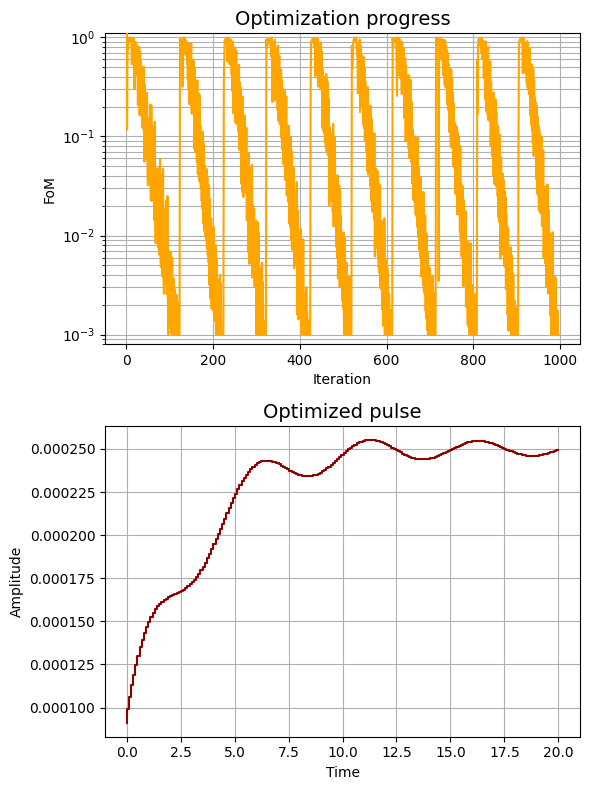

In [15]:
timestamp = "20250306_142317"

fomlist = load_fom(timestamp)
timegrid, pulse = load_best_results(timestamp)

plot.plot_optimization_process(fomlist, timegrid, pulse)

In [16]:
# SIMULATION PARAMETERS

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [17]:
opr.energies

[0.5,
 1.5000000000000007,
 2.4999999999999973,
 3.4999999999999964,
 4.4999999999999885,
 5.499999999999995,
 6.499999999999993,
 7.499999999999993]

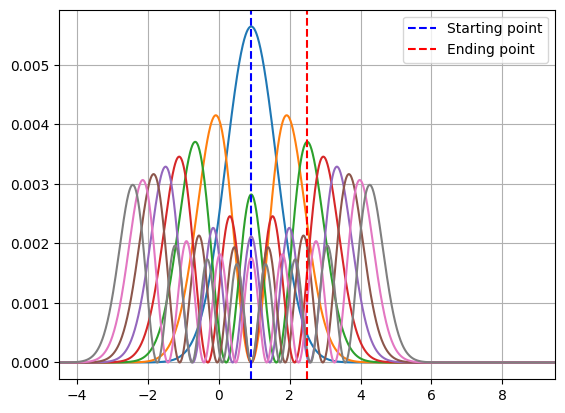

In [18]:
plot.plot_wavefunctions(par, opr)

In [19]:
opr.time_evolution(par, fixed_potential=False)

In [20]:
opr.energies

[0.50200646747241,
 1.5020090979191556,
 2.502011728365894,
 3.5020143588126182,
 4.502016989259381,
 5.502019619706099,
 6.5020222501528275,
 7.502024880599575]

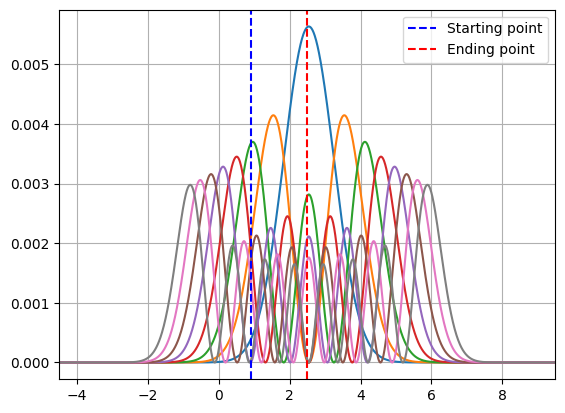

In [21]:
plot.plot_wavefunctions(par, opr)

In [22]:
opr.infidelity()

0.0010000000000000000208

In [23]:
opr.time_evolution(par, fixed_potential=True)

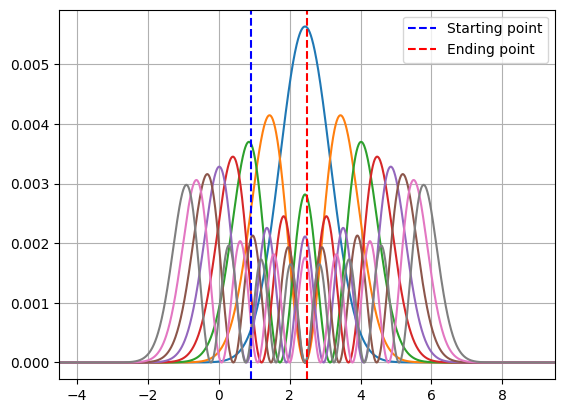

In [24]:
plot.plot_wavefunctions(par, opr)

In [25]:
opr.energies

[0.5020089475989522,
 1.5020119934740406,
 2.502015039349103,
 3.502018085224178,
 4.502021131099278,
 5.502024176974326,
 6.502027222849419,
 7.502030268724496]

In [26]:
opr.average_infidelity

0.0010000000000000000208

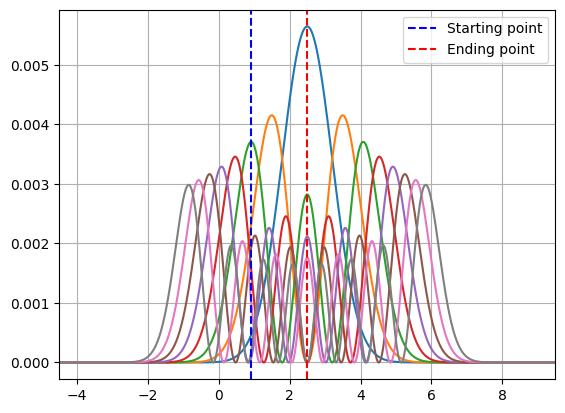

In [27]:
plot.plot_wavefunctions(par, opr, shifted=True)